In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import sys
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
# function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    #plt.xticks(xlocations, labels, rotation=90)
    #plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#-------------------data preprocessing----------------------------#
data = sio.loadmat('face.mat')
face_data=data['X']
c=data['l']
num_pix = 2576
num_img = face_data.shape[1] # num_img=520
num_pix = face_data.shape[0]
n_components = 9 # in total 9 principal components
img_idx_train = []
img_idx_test = []
for i in range(num_img):
    if i%10>8: #last 1 feed into test set
        img_idx_test.append(i)
    else:
        img_idx_train.append(i)
#training set
img_train = np.delete(face_data, img_idx_test, 1) # 2576*img_train.shape[1]
#test set
img_test = np.delete(face_data, img_idx_train, 1) # 2576*img_test.shape[1]

In [2]:
num_class = 52
#average faces per class
faces_per_class = int(img_train.shape[1]/num_class)
class_mean=np.zeros((num_pix,num_class))
for i in range(52):
    class_mean[:,i]=face_data[:,i*10:i*10+9].mean(axis=1)
#partition class mean into 52 sub matrices
class_mean_split = np.split(class_mean, 52, axis = 1)    
#partition img_train into 52 submatrices
img_train_split = np.split(img_train, 52, axis = 1)
#normalisation 
for i in range(num_class):
    img_train_split[i] =    img_train_split[i] - np.squeeze(class_mean_split[i])[:,None]
# pca = PCA(n_components=n_components, svd_solver='randomized',
#           whiten=False)
#eigenfaces is a list of numpy arrays
eigenfaces = []
for i in range(num_class):
    S=np.divide(np.matmul(img_train_split[i].T,img_train_split[i]),9)
    eigval, eigvec = np.linalg.eig(S)
    eigval.tolist()
#-------------------pca using sklearn-------------------------------#
#     pca.fit(img_train_split[i])
#     eigvec = pca.components_
#     eigval = pca.singular_values_
#     eigval.tolist()
    #Sorted eigenValues and eigenVectors
    idx = eigval.argsort()[::-1] 
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]
    eigvec_pseudo = np.matmul(img_train_split[i],eigvec) # 2576*9 
    eigvec_pseudo = preprocessing.normalize(eigvec_pseudo, norm='l2', axis=0)
    eigenfaces.append(eigvec_pseudo)

In [3]:
#--------------------example plot DO NOT USE ----------------------------#
# img2test = 38
# eigen2use = 23
# face_proj = np.matmul((img_test[:,img2test] - class_mean[:,eigen2use]).T, eigenfaces[eigen2use]) #img_train.shape[1]*M
# face_recon = np.zeros((1,2576))
# for i in range(n_components):
#     face_recon = np.add(face_proj[i] * eigenfaces[eigen2use][:,i], face_recon)
# face_recon += class_mean[:,eigen2use]
# #conparision between original face and reconstruction
# face_recon2_plt = np.reshape(face_recon ,(46,56)).T
# plt.subplot(1, 2, 1)
# plt.imshow(face_recon2_plt, cmap = 'gist_gray')
# img2plt = np.reshape(img_test[:,img2test] ,(46,56)).T
# plt.subplot(1, 2, 2)
# plt.imshow(img2plt, cmap = 'gist_gray')
# error = np.linalg.norm(face_recon - img_test[:,img2test])
# print(error)
# plt.plot(eigval)
# temp = face_recon - img_test[:,img2test]
# img2plt = np.reshape(temp ,(46,56)).T
# plt.imshow(img2plt, cmap = 'gist_gray')

In [21]:
# ------------success rate with fixed M-------------#
y_true = np.zeros(52)
y_pred = np.zeros(52)
accuracy = 0
true_counter = 0
for img2test in range(num_class):
    idx_pred = 0
    min_error = sys.float_info.max
    error = 0
    for eigen2use in range(52):
        face_proj = np.matmul((img_test[:,img2test] - class_mean[:,eigen2use]).T, eigenfaces[eigen2use])
        face_recon = np.zeros((2576,1)).T
        for i in range(n_components-1):
            face_recon = np.add(face_proj[i] * eigenfaces[eigen2use][:,i], face_recon)
        face_recon +=  class_mean[:,eigen2use]#class_mean_split[eigen2use].T
        face_recon = np.squeeze(face_recon.T)
        error = np.linalg.norm(face_recon - img_test[:,img2test])
        if error <= min_error:
            min_error = error
            idx_pred = eigen2use 
    y_true[img2test] = img2test
    y_pred[img2test] = idx_pred
    if idx_pred == img2test:
        true_counter +=1
        accuracy = true_counter/num_class

print("sucess rate within 52 test images: %f" %accuracy)

sucess rate within 52 test images: 0.884615


In [12]:
# ------------success rate with various M-------------#
y_true = np.zeros(52)
y_pred = np.zeros(52)
accuracy = np.zeros(9)
for M in range (1,10):
    true_counter = 0
    for img2test in range(num_class):
        idx_pred = 0
        min_error = sys.float_info.max
        error = 0
        for eigen2use in range(52):
            face_proj = np.matmul((img_test[:,img2test] - class_mean[:,eigen2use]).T, eigenfaces[eigen2use])
            face_recon = np.zeros((2576,1)).T
            for i in range(M):
                face_recon = np.add(face_proj[i] * eigenfaces[eigen2use][:,i], face_recon)
            face_recon +=  class_mean[:,eigen2use]#class_mean_split[eigen2use].T
            face_recon = np.squeeze(face_recon.T)
            error = np.linalg.norm(face_recon - img_test[:,img2test])
            if error <= min_error:
                min_error = error
                idx_pred = eigen2use 
        y_true[img2test] = img2test
        y_pred[img2test] = idx_pred
        if idx_pred == img2test:
            true_counter +=1
            accuracy[M-1] = true_counter/num_class

# print("sucess rate within 52 test images: %f" %accuracy)

[0.82692308 0.86538462 0.86538462 0.86538462 0.86538462 0.86538462
 0.88461538 0.88461538 0.84615385]


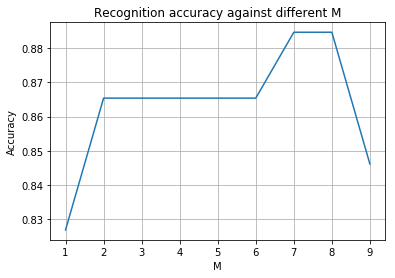

In [20]:
#--------plot accuracy graph--------------#
print(accuracy)
x=np.linspace(1,9,num=9)
plt.plot(x,accuracy)
plt.xlabel('M')
plt.ylabel('Accuracy')
plt.title('Recognition accuracy against different M')
plt.grid(b=True, which='both')
plt.show()

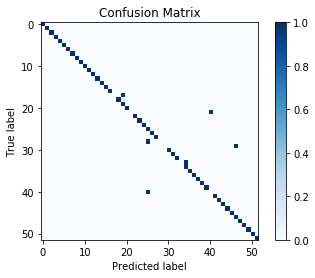

In [24]:
#--------plot confusion matrix--------------#
labels = list(set(y_true))
#use sklearn
conf_mat = confusion_matrix(y_true, y_pred, labels = labels)
#two types of confusion matrix, one is run once, another is record 52 test faces
plot_confusion_matrix(conf_mat)

In [6]:
# ---------- example success and failure cases ------------#
idx_pred = 0
img2test = 50 #self-defined 
min_error = sys.float_info.max
error = 0
for eigen2use in range(52):
    face_proj = np.matmul((img_test[:,img2test] - class_mean[:,eigen2use]).T, eigenfaces[eigen2use])
    face_recon = np.zeros((2576,1)).T
    for i in range(n_components):
        face_recon = np.add(face_proj[i] * eigenfaces[eigen2use][:,i], face_recon)
    face_recon +=  class_mean[:,eigen2use]#class_mean_split[eigen2use].T
    face_recon = np.squeeze(face_recon.T)
    error = np.linalg.norm(face_recon - img_test[:,img2test])
    if error <= min_error:
        min_error = error
        idx_pred = eigen2use 
print("predicted index: %d ; True index %d" %(idx_pred, img2test))

predicted index: 50 ; True index 50
